# Final Project - Kalkulator Pajak

## Perkenalan
Tim :
- Gede Aldi Vyacta Pranayena Sudirga
- Mesayu Puspita
- Muhammad Amri Hakim
- Vania Alya Qonita

Objektif : Prediksi Nilai Kurs dalam Kalkulator Bea Cukai untuk Menghitung Biaya Pajak Barang Pengiriman ke Indonesia.

## Import Libraries

In [1]:
# Melakukan import libraries yang akan digunakan
import pandas as pd
import numpy as np
# Library untuk visualisasi data
import matplotlib.pyplot as plt
import seaborn as sns
# Library untuk korelasi
from scipy import stats
# Library untuk model saving
import pickle
# Library untuk evaluasi
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
# Library untuk handling warning
import warnings
warnings.filterwarnings('ignore')

# ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima.model import ARIMA

# Deep Learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow as tf
import numpy as np
from tensorflow.keras.regularizers import L2
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

## Data Loading

In [2]:
# Melakukan loading data currency
df = pd.read_csv('JPY-2001.csv')
# Menampilkan hasil data
df

,Date,Close
0,1/2/2001 23:58:00,82.779720
1,1/3/2001 23:58:00,83.450457
2,1/4/2001 23:58:00,81.402360
3,1/5/2001 23:58:00,81.365392
4,1/8/2001 23:58:00,81.567614
...,...,...
7911,4/30/2024 23:58:00,103.229300
7912,5/1/2024 23:58:00,104.095000
7913,5/2/2024 23:58:00,105.240100
7914,5/3/2024 23:58:00,104.326400


In [ ]:
# Menampilkan 10 data awal tabel dengan head
df.head(10)

,Date,Close
0,1/2/2001 23:58:00,82.779720
1,1/3/2001 23:58:00,83.450457
2,1/4/2001 23:58:00,81.402360
3,1/5/2001 23:58:00,81.365392
4,1/8/2001 23:58:00,81.567614
5,1/9/2001 23:58:00,81.019903
6,1/10/2001 23:58:00,81.580077
7,1/11/2001 23:58:00,81.418030
8,1/12/2001 23:58:00,80.822149
9,1/15/2001 23:58:00,79.296449


In [ ]:
# Menampilkan 10 data akhir data menggunakan tail
df.tail(10)

,Date,Close
7906,4/25/2024 23:58:00,104.1632
7907,4/26/2024 23:58:00,102.5724
7908,4/27/2024 23:58:00,102.5624
7909,4/28/2024 23:58:00,102.4452
7910,4/29/2024 23:58:00,103.9984
7911,4/30/2024 23:58:00,103.2293
7912,5/1/2024 23:58:00,104.0950
7913,5/2/2024 23:58:00,105.2401
7914,5/3/2024 23:58:00,104.3264
7915,5/4/2024 23:58:00,104.3789


## Exploratory Data Analysis

### Data Understanding

In [ ]:
# Melihat kolom yang tersedia
df.columns

Index(['Date', 'Close'], dtype='object')

In [ ]:
# Melihat tipe data yang tersedia
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7916 entries, 0 to 7915
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    7916 non-null   object 
 1   Close   7916 non-null   float64
dtypes: float64(1), object(1)
memory usage: 123.8+ KB


In [ ]:
# Melihat jumlah data yang tersedia
df.shape

(7916, 2)

In [ ]:
# Mengecek central tendency menggunakan describe
df.describe()

,Close
count,7916.000000
mean,109.259895
std,197.600643
min,67.939740
25%,87.703890
50%,108.631973
75%,120.565905
max,12480.170000


In [ ]:
# Mengecek duplikasi pada data
df.duplicated().value_counts()

False    7916
Name: count, dtype: int64

In [ ]:
# Mengecek nilai null
df.isnull().sum()

Date     0
Close    0
dtype: int64

### Data Visualization

Text(0, 0.5, 'Currency Price')

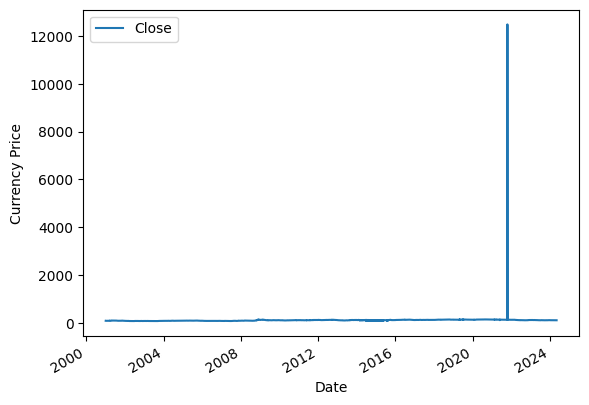

In [3]:
# Plot the data

df.columns = ['Date', 'Close']
df.Date = pd.to_datetime(df.Date)
df.set_index('Date',inplace=True)
df.plot()
plt.xlabel('Date')
plt.ylabel('Currency Price')

## Feature Engineering


In [30]:
#splitting train and test
train=df[:6000]
test=df[6000:]

## Model Definition & Training

### Moving Average

In [31]:
# Membuat hasil prediksi dengan rolling window 12 hari
predictions = []

window_size = 12
for i in range(len(test)):
    if i < window_size:
        moving_avg = train['Close'].mean()
    else:
        moving_avg = train['Close'].iloc[-window_size:].mean()

    predictions.append(moving_avg)

    train = pd.concat([train, test.iloc[[i]]], ignore_index=True)

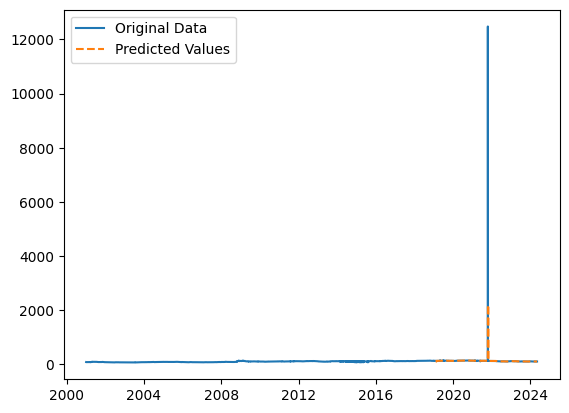

In [32]:
# Melakukan visualisasi plot data
plt.plot(df['Close'], label='Original Data')
plt.plot(test.index, predictions, label='Predicted Values', linestyle='--')
plt.legend()
plt.show()

In [33]:
mae = mean_absolute_error(test.Close, predictions)
rmse = sqrt(mean_squared_error(test.Close, predictions))

# Menampilkan hasil
print("MAE:", mae)
print("RMSE:", rmse)

MAE: 25.809249342755034
RMSE: 412.78244173021267


### ARIMA

#### Checking Stationary

In [ ]:
# Create a function to check stationarity

def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [ ]:
# Check stationarity of the dataset

check_stationarity(df['Close'])

ADF Statistic: -13.254672
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


#### ACF & PACF

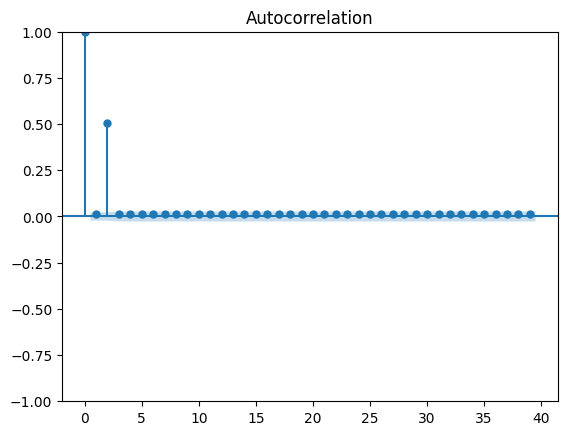

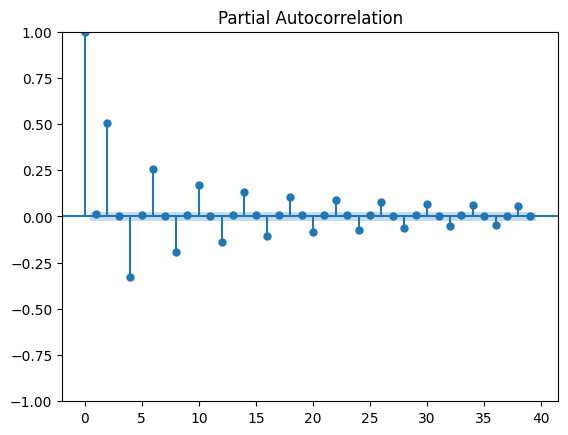

In [ ]:
# Plot ACF & PACF from the original dataset

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df['Close'])
plot_pacf(df['Close'])
plt.show()

Dari hasil plot, dapat terlihat bahwa rekomendasi untuk pembuatan model ARIMA adalah sebagai berikut.
- q = 2
- d = 0
- p = 2,4,6,8,10,12,14,16,18,20

Dari beberapa pilihan tersebut, kita akan lakukan pencarian model ARIMA terbaik.

#### ARIMA Model

In [ ]:
# Create a function to find best model

def find_best_model(data, num_p, num_d, num_q):
  df = pd.DataFrame() #We make a pandas dataframe to ease our work, you can use any way that makes you comfortable and work easly
  pdq = [[],[],[]] #This list for storing the combinations of p and q
  aic = [] # This list for storing aic value
  for p in range(num_p + 1): #plus one is to make the range up to num_p since python range only ranging from 0 to N-1
    for d in range(num_d + 1):
      for q in range(num_q + 1):
        # #if p!=0 and q!=0: #this logic will avoid (0,0) value which is not correct
        try: #Using exception to avoid the error while training the model with certain p and q value
          model = ARIMA(data, order=(p, d, q))
          result = model.fit()
          pdq[0].append(p)
          pdq[1].append(d)
          pdq[2].append(q)
          aic.append(result.aic)
        except:
          pass #If there is an error caused by the calculation, it will be skipped to the next iteration

  df['p'] = pdq[0]
  df['d'] = pdq[1]
  df['q'] = pdq[2]
  df['AIC'] = aic

  df.sort_values('AIC', inplace=True)

  return df.p.iloc[0], df.d.iloc[0], df.q.iloc[0], df.AIC.iloc[0], df

In [ ]:
list_p = [2,4,6,8,10,12,14,16,18,20]
list_d = [0]
list_q = [2]

df_arima = pd.DataFrame()
pdq = [[],[],[]] #This list for storing the combinations of p and q
aic = [] # This list for storing aic value
for p in list_p:
    for d in list_d:
        for q in list_q:
            model = ARIMA(df['Close'], order=(p, d, q))
            result = model.fit()
            pdq[0].append(p)
            pdq[1].append(d)
            pdq[2].append(q)
            aic.append(result.aic)
df_arima['p'] = pdq[0]
df_arima['d'] = pdq[1]
df_arima['q'] = pdq[2]
df_arima['AIC'] = aic

df_arima.sort_values('AIC', inplace=True)
df_arima

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


,p,d,q,AIC
0,2,0,2,100728.895086
1,4,0,2,100732.206536
2,6,0,2,100736.330818
7,16,0,2,100755.838153
8,18,0,2,100781.245917
9,20,0,2,100783.714178
6,14,0,2,100792.627783
5,12,0,2,100797.093684
3,8,0,2,100797.553618
4,10,0,2,100809.949640


Dari hasil, kita dapat melihat bahwa model terbaik dengan kombinasi
- p = 2
- d = 0
- q = 2

Kita akan gunakan kombinasi ini untuk membuat model ARIMA.

In [35]:
# Train ARIMA with best combinations

model_arima_202 = ARIMA(df['Close'], order=(2, 0, 2))
result_model_arima_202 = model_arima_202.fit()

print('The AIC is ', result_model_arima_202.aic)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



The AIC is  100728.8950856805


In [36]:
# Prediksi model pada data
new_pred1 = result_model_arima_202.predict(start="2001-01-02", end="2024-05-04", dynamic=False)
new_pred1 = pd.DataFrame(new_pred1)
new_pred1.columns = ['Close_predict']

all_dataset_with_pred1 = pd.concat([df, new_pred1], axis=1)
all_dataset_with_pred1

,Close,Close_predict
Date,,
2001-01-02 23:58:00,82.779720,109.259432
2001-01-03 23:58:00,83.450457,109.022331
2001-01-04 23:58:00,81.402360,95.845127
2001-01-05 23:58:00,81.365392,96.232133
2001-01-08 23:58:00,81.567614,99.360051
...,...,...
2024-04-30 23:58:00,103.229300,107.282663
2024-05-01 23:58:00,104.095000,107.798040
2024-05-02 23:58:00,105.240100,105.188433


In [37]:
# Melakukan forecasting pada data
len_dataset = df.shape[0]
len_predict = len_dataset + 12


new_pred = result_model_arima_202.predict(len_dataset, len_predict)
new_pred = pd.DataFrame(new_pred)
new_pred.columns = ['Close_forecast']

last_date = df.index.max()
date_range = pd.date_range(start=last_date, periods=13)
new_pred.index = date_range

# Menggabungkan prediksi dengan dataset asli
all_dataset_with_pred = pd.concat([all_dataset_with_pred1, new_pred], axis=1)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



In [38]:
all_dataset_with_pred

,Close,Close_predict,Close_forecast
2001-01-02 23:58:00,82.779720,109.259432,NaN
2001-01-03 23:58:00,83.450457,109.022331,NaN
2001-01-04 23:58:00,81.402360,95.845127,NaN
2001-01-05 23:58:00,81.365392,96.232133,NaN
2001-01-08 23:58:00,81.567614,99.360051,NaN
...,...,...,...
2024-05-12 23:58:00,NaN,NaN,109.259432
2024-05-13 23:58:00,NaN,NaN,109.259432
2024-05-14 23:58:00,NaN,NaN,109.259432
2024-05-15 23:58:00,NaN,NaN,109.259432


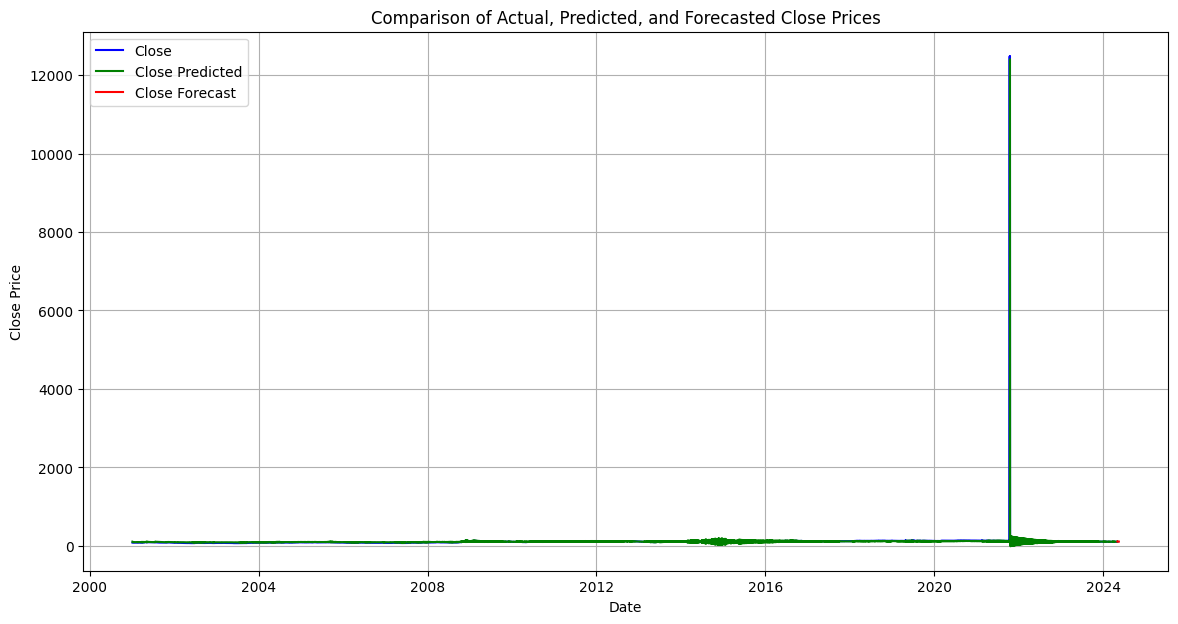

In [ ]:
# Melakukan visualisasi data
plt.figure(figsize=(14, 7))
plt.plot(all_dataset_with_pred.index, all_dataset_with_pred['Close'], label='Close', color='blue', linestyle='-')  # Data asli
plt.plot(all_dataset_with_pred.index, all_dataset_with_pred['Close_predict'], label='Close Predicted', color='green', linestyle='-')  # Data prediksi
plt.plot(all_dataset_with_pred.index, all_dataset_with_pred['Close_forecast'], label='Close Forecast', color='red', linestyle='-')  # Data forecast

plt.title('Comparison of Actual, Predicted, and Forecasted Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

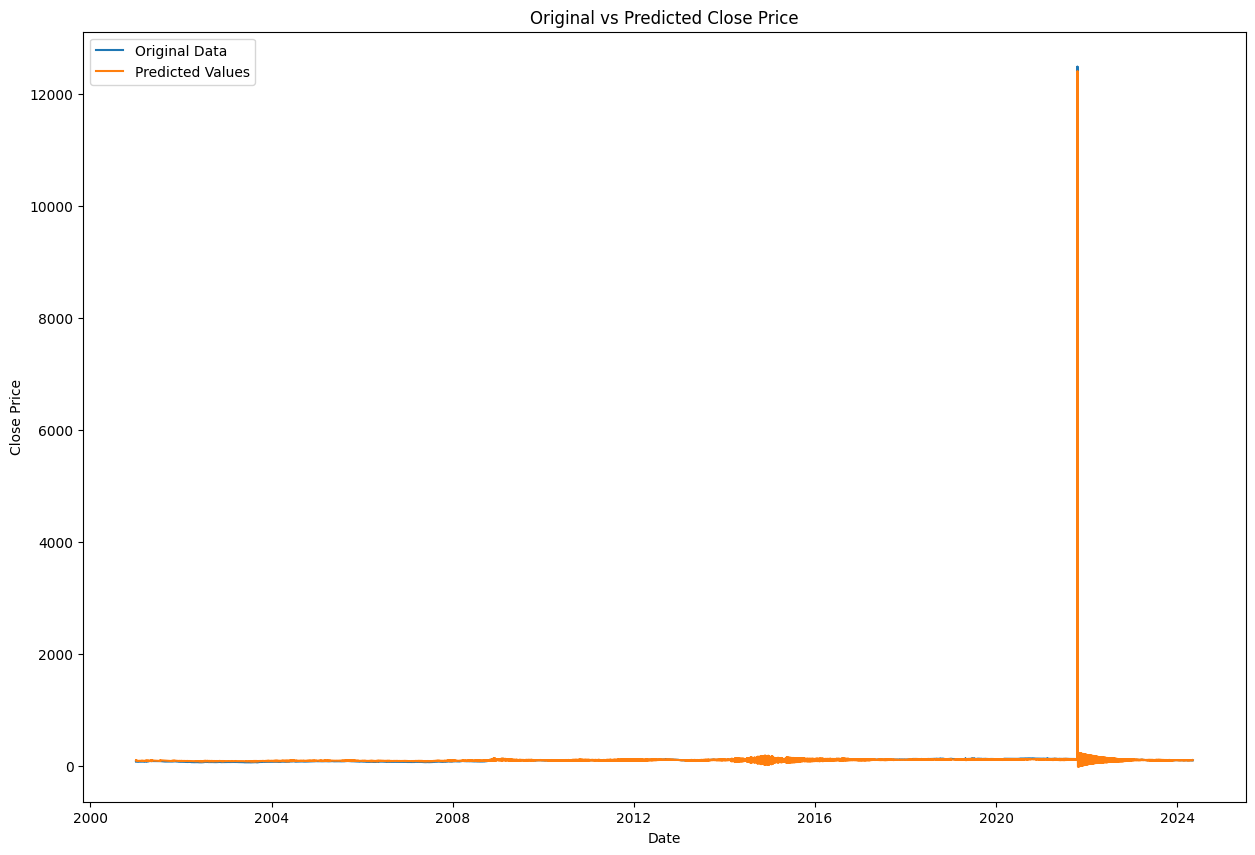

In [39]:
plt.figure(figsize=(15, 10))
plt.plot(df.index, df['Close'], label='Original Data')


# Plot predicted values overlapping the original data
plt.plot(all_dataset_with_pred.index, all_dataset_with_pred['Close_predict'], label='Predicted Values', linestyle='-')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Original vs Predicted Close Price')
plt.legend()
plt.show()

### Regression

#### Creating Dataset
Data akan menggunakan lag untuk menjadi fitur. Lag yang digunakan rekomendasi berada pada kisaran 3-6 lag.

In [4]:
# Membuat dataset menggunakan lag
df_reg = df.copy()
df_reg = df_reg.drop(['Close'], axis=1)
df_reg['lag_5'] = df['Close'].shift(5)
df_reg['lag_4'] = df['Close'].shift(4)
df_reg['lag_3'] = df['Close'].shift(3)
df_reg['lag_2'] = df['Close'].shift(2)
df_reg['lag_1'] = df['Close'].shift(1)
df_reg['y'] = df['Close']

# Menampilkan dataset
df_reg

,lag_5,lag_4,lag_3,lag_2,lag_1,y
Date,,,,,,
2001-01-02 23:58:00,NaN,NaN,NaN,NaN,NaN,82.779720
2001-01-03 23:58:00,NaN,NaN,NaN,NaN,82.779720,83.450457
2001-01-04 23:58:00,NaN,NaN,NaN,82.779720,83.450457,81.402360
2001-01-05 23:58:00,NaN,NaN,82.779720,83.450457,81.402360,81.365392
2001-01-08 23:58:00,NaN,82.77972,83.450457,81.402360,81.365392,81.567614
...,...,...,...,...,...,...
2024-04-30 23:58:00,104.1632,102.57240,102.562400,102.445200,103.998400,103.229300
2024-05-01 23:58:00,102.5724,102.56240,102.445200,103.998400,103.229300,104.095000
2024-05-02 23:58:00,102.5624,102.44520,103.998400,103.229300,104.095000,105.240100


#### Cleaning Data

In [5]:
# Melakukan pengecekan nilai null pada dataset
df_reg.isnull().sum()

lag_5    5
lag_4    4
lag_3    3
lag_2    2
lag_1    1
y        0
dtype: int64

In [6]:
# Melakukan dropping nilai null pada data
df_reg.dropna(inplace=True)

# Mengecek hasil dropping nilai null
df_reg.isnull().sum()

lag_5    0
lag_4    0
lag_3    0
lag_2    0
lag_1    0
y        0
dtype: int64

#### Visualizations

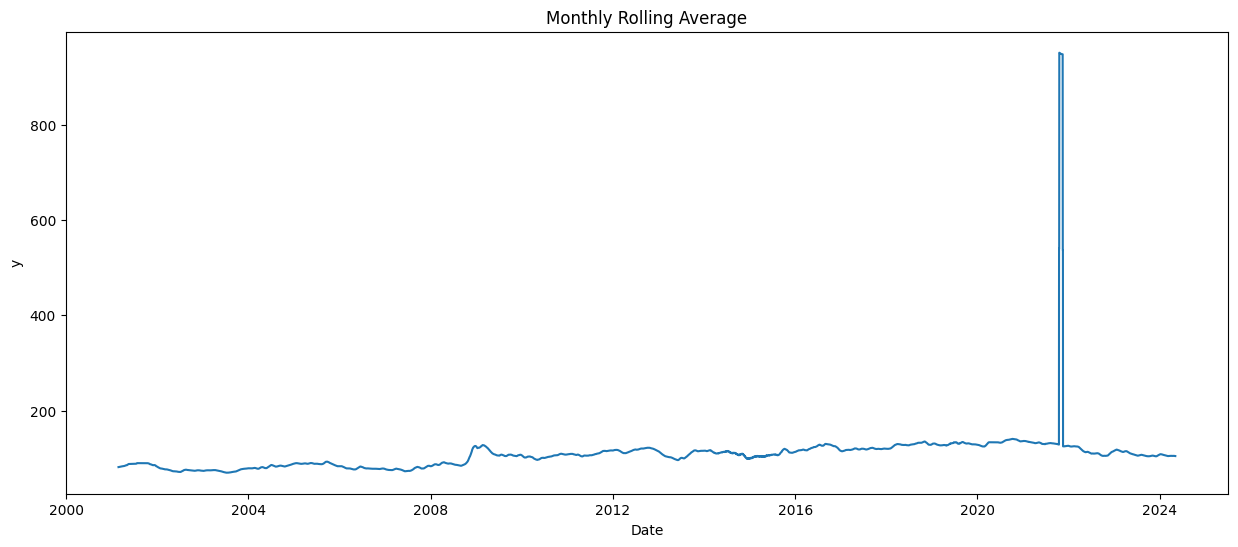

In [7]:
# Membuat visualisasi rolling per bulan
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x = df_reg.index, y = df_reg["y"].rolling(30).mean(), data = df_reg, ax=ax)
ax.set_title("Monthly Rolling Average");

In [8]:
# Mengecek korelasi
df_reg.corr()

,lag_5,lag_4,lag_3,lag_2,lag_1,y
lag_5,1.000000,0.011826,0.505885,0.011916,0.011962,0.012015
lag_4,0.011826,1.000000,0.011824,0.505884,0.011914,0.011959
lag_3,0.505885,0.011824,1.000000,0.011822,0.505883,0.011912
lag_2,0.011916,0.505884,0.011822,1.000000,0.011820,0.505882
lag_1,0.011962,0.011914,0.505883,0.011820,1.000000,0.011817
y,0.012015,0.011959,0.011912,0.505882,0.011817,1.000000


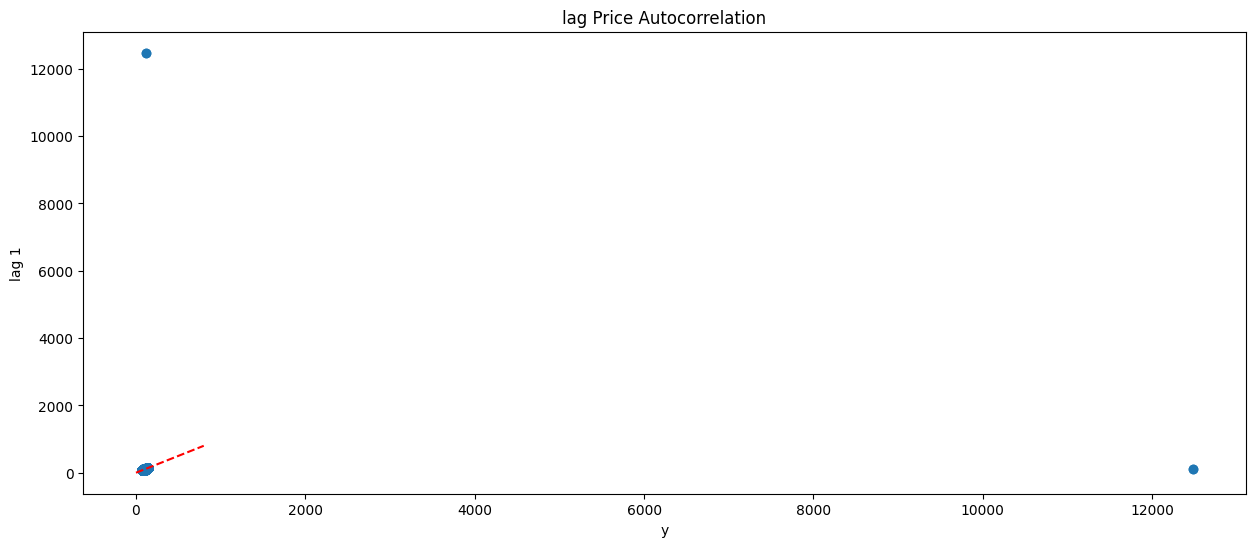

In [9]:
# Membuat visualisasi korelasi antara lag 0 dan lag 1
fig, ax = plt.subplots(figsize=(15, 6))
ax.scatter(x=df_reg["y"], y=df_reg["lag_1"])
ax.plot([0,800],[0,800],linestyle="--", color="red")
plt.xlabel("y")
plt.ylabel("lag 1")
plt.title("lag Price Autocorrelation");

#### Feature Engineering

In [10]:
# Split the data menjadi fitur dan target
target = "y"
y = df_reg[target]
X = df_reg.drop(columns= target)

#Split the data into train and test sets
cutoff = int(len(X) * 0.8)
X_train, y_train = X.iloc[:cutoff], y.iloc[:cutoff]
X_test, y_test = X.iloc[cutoff:], y.iloc[cutoff:]

<Axes: xlabel='Date'>

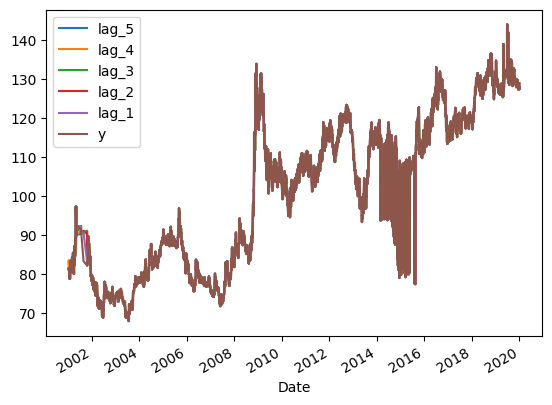

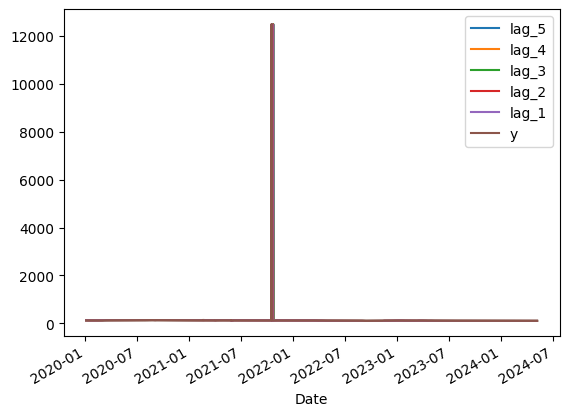

In [11]:
# Plotting data
df_reg[:len(X_train)].plot()
df_reg[len(X_train):].plot()

#### Model training

In [12]:
# Menentukan baseline MAE (persebaran nilai data)
y_pred_baseline = [y_train.mean()] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)
print("Mean Close Prices:", round(y_train.mean(), 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean Close Prices: 102.6
Baseline MAE: 16.65


In [13]:
from sklearn.linear_model import LinearRegression
# Melakukan modeling
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [14]:
# Melihat hasil nilai MAE training dan test
training_mae = mean_absolute_error(y_train, model.predict(X_train))
test_mae = mean_absolute_error(y_test, model.predict(X_test))
print("Training MAE:", round(training_mae, 2))
print("Test MAE:", round(test_mae, 2))

Training MAE: 1.12
Test MAE: 28.77


In [15]:
# Membuat dataset perbandingan y_test dan y_pred
df_pred_test = pd.DataFrame(
             {
             "y_test": y_test,
             "y_pred": model.predict(X_test)
             }
)
df_pred_test.head()

,y_test,y_pred
Date,,
2020-01-04 23:58:00,128.9495,128.157467
2020-01-05 23:58:00,129.1059,128.362659
2020-01-06 23:58:00,128.1513,128.621537
2020-01-07 23:58:00,128.3472,128.476140
2020-01-08 23:58:00,127.5151,128.528504


In [16]:
import plotly.express as px
# Melakukan visualisasi data prediksi dengan data asli
fig = px.line(df_pred_test, labels= {"value": "Close Price"}, title = "Linear Regression Model: Actual Prices vs. Predicted Prices.")
fig.show()

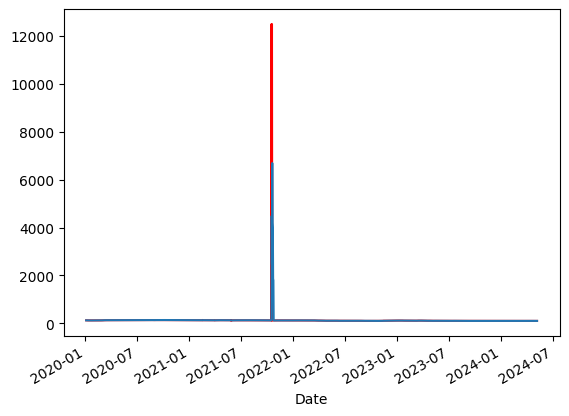

In [17]:
import matplotlib.pyplot as plt

df_pred_test['y_test'].plot(color='red')
plt.plot(df_pred_test['y_pred'])

In [18]:
# Check the MAE & RMSE
from sklearn.metrics import mean_absolute_error, mean_squared_error

print('MAE test  : ', mean_absolute_error(df_pred_test['y_test'], df_pred_test['y_pred']))
print('RMSE test : ', np.sqrt(mean_squared_error(df_pred_test['y_test'], df_pred_test['y_pred'])))

MAE test  :  28.768417924317394
RMSE test :  471.9765769026427


### LSTM

In [22]:
tf.random.set_seed(100)
tf.keras.backend.clear_session()

# Define the model_lstm
model_lstm = Sequential([
    LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1],1), kernel_regularizer=L2(0.001)),
    Dropout(0.2),
    LSTM(units=128, return_sequences=True, kernel_regularizer=L2(0.001)),
    Dropout(0.2),
    LSTM(units=128, kernel_regularizer=L2(0.001)),
    Dropout(0.2),
    Dense(units=64, activation='relu', kernel_regularizer=L2(0.001)),
    Dropout(0.2),
    Dense(units=1, kernel_regularizer=L2(0.001))
])

model_lstm.compile(optimizer='adam', loss='mae', metrics=['mae']) # Notice the change here

# Display model_lstm summary
model_lstm.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 128)            66560     
                                                                 
 dropout (Dropout)           (None, 5, 128)            0         
                                                                 
 lstm_1 (LSTM)               (None, 5, 128)            131584    
                                                                 
 dropout_1 (Dropout)         (None, 5, 128)            0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8

In [23]:
history_lstm = model_lstm.fit(X_train, y_train, epochs= 100, batch_size= 32)

Epoch 1/100
198/198 [==============================] - 29s 52ms/step - loss: 37.9466 - mae: 37.5742
Epoch 2/100
198/198 [==============================] - 5s 27ms/step - loss: 18.4797 - mae: 18.2024
Epoch 3/100
198/198 [==============================] - 7s 37ms/step - loss: 18.4748 - mae: 18.2535
Epoch 4/100
198/198 [==============================] - 5s 27ms/step - loss: 14.7567 - mae: 14.5345
Epoch 5/100
198/198 [==============================] - 7s 37ms/step - loss: 9.4813 - mae: 9.2223
Epoch 6/100
198/198 [==============================] - 6s 28ms/step - loss: 9.2585 - mae: 9.0036
Epoch 7/100
198/198 [==============================] - 7s 37ms/step - loss: 9.2162 - mae: 8.9684
Epoch 8/100
198/198 [==============================] - 6s 32ms/step - loss: 9.2722 - mae: 9.0306
Epoch 9/100
198/198 [==============================] - 7s 37ms/step - loss: 9.3144 - mae: 9.0795
Epoch 10/100
198/198 [==============================] - 5s 27ms/step - loss: 9.0557 - mae: 8.8241
Epoch 11/100
198/198

In [24]:
predictions = model_lstm.predict(X_test)

50/50 [==============================] - 2s 9ms/step


In [25]:
print('MAE test  : ', mean_absolute_error(y_test, predictions))
print('RMSE test : ', np.sqrt(mean_squared_error(y_test, predictions)))

MAE test  :  17.441961984763775
RMSE test :  439.04409566593193


## Model Evaluation

### Finding Best Model

In [26]:
# Membuat dictionary untuk menyimpan hasil mae dan rmse dari data

all_reports = {}
def performance_report(all_reports, y_test, y_pred_test, name):
  score_reports = {
      'MAE test' : mean_absolute_error(y_test, y_pred_test),
      'RMSE test' : np.sqrt(mean_squared_error(y_test, y_pred_test)),
  }
  all_reports[name] = score_reports
  return all_reports

In [27]:
# Menambahkan hasil Logistic Regression ke dalam dictionary
all_reports = performance_report(all_reports, df_pred_test['y_test'], df_pred_test['y_pred'], 'Linear Regression')
pd.DataFrame(all_reports)

,Linear Regression
MAE test,28.768418
RMSE test,471.976577


In [40]:
# Menambahkan hasil Moving Average ke dalam dictionary
all_reports = performance_report(all_reports, test['Close'], predictions, 'Moving Average')
pd.DataFrame(all_reports)

,Linear Regression,LSTM,Moving Average
MAE test,28.768418,17.441962,25.809249
RMSE test,471.976577,439.044096,412.782442


In [41]:
# Mengambil data untuk report arima
arima_report = all_dataset_with_pred.copy()
arima_report = arima_report.drop(['Close_forecast'], axis=1)
arima_report = arima_report.dropna(subset=['Close', 'Close_predict'])
arima_report

,Close,Close_predict
2001-01-02 23:58:00,82.779720,109.259432
2001-01-03 23:58:00,83.450457,109.022331
2001-01-04 23:58:00,81.402360,95.845127
2001-01-05 23:58:00,81.365392,96.232133
2001-01-08 23:58:00,81.567614,99.360051
...,...,...
2024-04-30 23:58:00,103.229300,107.282663
2024-05-01 23:58:00,104.095000,107.798040
2024-05-02 23:58:00,105.240100,105.188433
2024-05-03 23:58:00,104.326400,105.544914


In [42]:
# Menambahkan hasil ARIMA ke dalam dictionary
all_reports = performance_report(all_reports, arima_report['Close'], arima_report['Close_predict'], 'ARIMA')
pd.DataFrame(all_reports)

,Linear Regression,LSTM,Moving Average,ARIMA
MAE test,28.768418,17.441962,25.809249,14.130461
RMSE test,471.976577,439.044096,412.782442,140.074574


In [28]:
# Menambahkan hasil LSTM ke dalam dictionary
all_reports = performance_report(all_reports, y_test, predictions, 'LSTM')
pd.DataFrame(all_reports)

,Linear Regression,LSTM
MAE test,28.768418,17.441962
RMSE test,471.976577,439.044096


Dari hasil perbandingan nilai MAE dan RMSE, didapatkan model ARIMA memiliki hasil terbaik. Hasil linear regression akan dilakukan analisis lanjutan.

### Further Analysis
Dilakukan perbandingan min dan max dari test set dengan hasil prediksi.

In [ ]:
# Melihat data hasil
hasil = arima_report.copy()
hasil.head()

,Close,Close_predict
2001-01-02 23:58:00,82.779720,109.259432
2001-01-03 23:58:00,83.450457,109.022331
2001-01-04 23:58:00,81.402360,95.845127
2001-01-05 23:58:00,81.365392,96.232133
2001-01-08 23:58:00,81.567614,99.360051


In [ ]:
# Melihat min dan max dari data menggunakan describe
hasil.describe()

,Close,Close_predict
count,7916.000000,7916.000000
mean,109.259895,109.267207
std,197.600643,139.331345
min,67.939740,-8.798493
25%,87.703890,96.672014
50%,108.631973,107.667459
75%,120.565905,117.576198
max,12480.170000,12402.763559


Dari hasil didapatkan stat sebagai berikut.

| Stat | Prediksi | Nilai asli
| --- | --- | --- |
| Min | -8.79 | 67.93 |
| Max | 12402.76 | 12480.17 |
| Median | 107.66 | 108.63 |
| Mean | 109.26 | 109.25 |

Dapat terlihat bahwa terdapat beberapa insight : <br>
1. Hasil prediksi memiliki median dan mean yang cenderung relatif mirip dengan nilai asli.
2. Nilai prediksi memiliki batas minimum dan maximum yang lebih rendah.

Untuk melihat jumlah data yang termasuk ke dalam kategori dapat dilakukan analisis lebih lanjut.

In [ ]:
# Melakukan perhitunga jumlah data dimana Close_predict < Close asli
jum_lower_data = hasil[(hasil['Close_predict']<hasil['Close'])].count()
print(f"Jumlah data Close_predict lebih kecil dari Close asli adalah {jum_lower_data[0]}")
print("Keseluruhan jumlah data adalah ", len(hasil))
print("Persentase jumlah data lebih kecil adalah ", (jum_lower_data[0]/len(hasil))*100, "%")

Jumlah data Close_predict lebih kecil dari Close asli adalah 3641
Keseluruhan jumlah data adalah  7916
Persentase jumlah data lebih kecil adalah  45.995452248610405 %


Jika dilihat melalui analisis lebih lanjut, terlihat bahwa data y_pred yang lebih kecil dari y_test sebanyak 45%. Hal ini mengindikasikan bahwa 55% sisanya memprediksikan hasil yang lebih tinggi. Oleh karena itu, dapat terlihat bahwa **model memprediksikan data dengan kecenderungan lebih tinggi dari nilai asli**.

In [ ]:
# Melakukan pengecekan terkait asumsi prediksi > Close
jum_higher_data = hasil[(hasil['Close_predict']>hasil['Close'])].count()
print(f"Jumlah data Close_predict lebih besar dari Close asli adalah {jum_higher_data[0]}")
print("Keseluruhan jumlah data adalah ", len(hasil))
print("Persentase jumlah data lebih kecil adalah ", (jum_higher_data[0]/len(hasil))*100, "%")

Jumlah data Close_predict lebih besar dari Close asli adalah 4275
Keseluruhan jumlah data adalah  7916
Persentase jumlah data lebih kecil adalah  54.00454775138959 %


Dari hasil eksplorasi didapatkan bahwa asumsi tersebut terbukti benar.

## Model Saving

In [ ]:
# Melakukan penyimpanan model regreasi linear sebagai pickle file
model_pkl_file = "bea_cukai_jpy_arima.pkl"

with open(model_pkl_file, 'wb') as file:
    pickle.dump(result_model_arima_202, file)

## Model Inference

In [ ]:
# Membuat fungsi untuk prediksi arima
def forecast_arima(model, data, day):
  # Melakukan forecasting pada data
  len_dataset = data.shape[0]
  len_predict = len_dataset + day


  new_pred = model.predict(len_dataset, len_predict)
  new_pred = pd.DataFrame(new_pred)
  new_pred.columns = ['Close_forecast']

  last_date = data.index.max()
  date_range = pd.date_range(start=last_date, periods=day+1)
  new_pred.index = date_range
  return new_pred

In [ ]:
# Forecast data for the next 2 weeks
forecast_arima(result_model_arima_202,df,2)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



,Close_forecast
2024-05-04 23:58:00,108.002096
2024-05-05 23:58:00,104.395075
2024-05-06 23:58:00,109.223518


### Export function

In [ ]:
# Exporting the related functions
%%writefile arima_predict.py
# Import library
from datetime import datetime
import pandas as pd

def forecast_arima(model, data, day):
  # Melakukan forecasting pada data
  len_dataset = data.shape[0]
  len_predict = len_dataset + day


  new_pred = model.predict(len_dataset, len_predict)
  new_pred = pd.DataFrame(new_pred)
  new_pred.columns = ['Close_forecast']

  last_date = data.index.max()
  date_range = pd.date_range(start=last_date, periods=day+1)
  new_pred.index = date_range
  return new_pred

Writing arima_predict.py


## Conclusion
Dengan objektif untuk membuat kalkulator untuk pajak bea cukai dengan prediksi pada kurs, didapatkan bahwa model ARIMA merupakan model terbaik untuk memprediksi kurs JPY.